<a href="https://colab.research.google.com/github/hawat629/comerce/blob/master/Defi%20toulouse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cette approche est basée sur l'utilisation de réseaux de neurones auto-encodeurs. 
Il est basé sur des principes similaires à ceux de l'analyse statistique, mais avec quelques légères différences.

Un autoencodeur est un type de réseau neuronal artificiel utilisé pour apprendre des codages de données efficaces sans surveillance. Le but d'un autoencodeur est d'apprendre une représentation (encodage) pour un ensemble de données, typiquement pour la réduction de dimensionnalité. Parallèlement au côté de réduction, un côté de reconstruction est appris, où l'autoencodeur essaie de générer à partir du codage réduit une représentation aussi proche que possible de son entrée d'origine.

Sur le plan architectural, la forme la plus simple d'un autoencodeur est un réseau neuronal non récurrent à action directe très similaire aux nombreux perceptrons à couche unique qui fait un perceptron multicouche (MLP) - ayant une couche d'entrée, une couche de sortie et une ou plusieurs couches cachées les reliant - mais avec la couche de sortie ayant le même nombre de nœuds que la couche d'entrée, et dans le but de reconstruire ses propres entrées.
en effet on assayer de travailler pas sur les données mes sur les transformés des fouriers des données car c'est le mieux pour des series temporaires .

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Classification/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#!pip install h5py
import h5py

on apporte les data

In [0]:
train = h5py.File(path + "train.hdf5", "r+")
df_train = train["dftrain"]
X_train = np.asarray(df_train["block0_values"])
test = h5py.File(path + "test.hdf5", "r+")
df_test = test["dffinal"]
X_test = np.asarray(df_test["block0_values"])

on trouve les transformés des fouriers

In [0]:
train_fft = np.fft.fft(X_train)
test_fft = np.fft.fft(X_test)

apporter les libraries d'autoencodeur

In [0]:
from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

In [0]:
seed(10)
set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [0]:
history=model.fit(np.array(train_fft),np.array(train_fft),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)




Train on 1593 samples, validate on 84 samples
Epoch 1/100







/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


1593/1593 [==============================] - 6s 4ms/step - loss: 27348.4846 - val_loss: 11239.1025
Epoch 2/100
1593/1593 [==============================] - 5s 3ms/step - loss: 27304.6924 - val_loss: 11236.3093
Epoch 3/100
1593/1593 [==============================] - 5s 3ms/step - loss: 27241.2017 - val_loss: 11240.1796
Epoch 4/100
1593/1593 [==============================] - 5s 3ms/step - loss: 27240.6297 - val_loss: 11232.4365
Epoch 5/100
1593/1593 [==============================] - 5s 3ms/step - loss: 27417.3670 - val_loss: 11234.7539
Epoch 6/100
1593/1593 [==============================] - 5s 3ms/step - loss: 27124.9895 - val_loss: 11242.1516
Epoch 7/100
1593/1593 [==============================] - 5s 3ms/step - loss: 27115.6801 - val_loss: 11238.6235
Epoch 8/100
1593/1593 [==============================] - 5s 3ms/step - loss: 26973.6492 - val_loss: 11248.7369
Epoch 9/100
1593/1593 [==============================] - 6s 3ms/step - loss: 26963.0302 - val_loss: 11280.9668
Epoch 10/100


In [0]:
import seaborn as sns
sns.set(color_codes=True)

on plot l'histograme pour savoir choisir un treshold convenable au donné.

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 300)

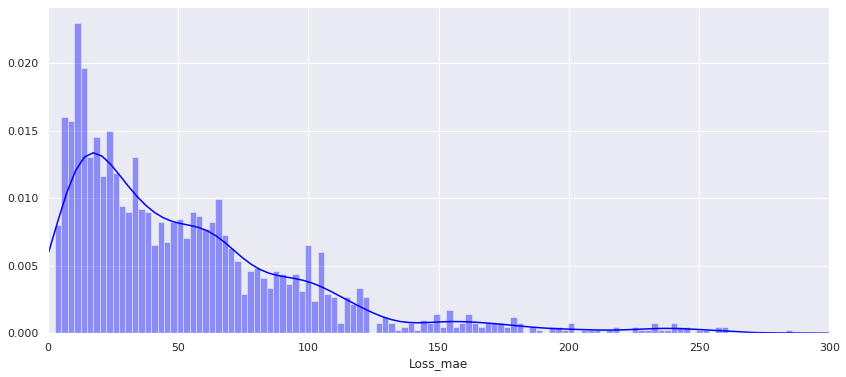

In [0]:
X_pred = model.predict(train_fft)
X_pred = pd.DataFrame(X_pred, 
                      columns=pd.DataFrame(train_fft).columns)
X_pred.index = pd.DataFrame(train_fft).index

scored = pd.DataFrame(index= pd.DataFrame(train_fft).index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-train_fft), axis = 1)
plt.figure(figsize=(14,6))
sns.distplot(scored['Loss_mae'],
             bins = 150, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,300])

In [0]:
X_pred = model.predict(test_fft)
X_pred = pd.DataFrame(X_pred, 
                      columns=pd.DataFrame(test_fft).columns)
X_pred.index = pd.DataFrame(test_fft).index

scored = pd.DataFrame(index=pd.DataFrame(test_fft).index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-pd.DataFrame(test_fft)), axis = 1)
scored['Threshold'] = 200
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


,Loss_mae,Threshold,Anomaly
0,7.872632,200,False
1,3.679184,200,False
2,139.499716,200,False
3,3.123840,200,False
4,6.470415,200,False


list des indices d'anomalies detectés


In [0]:
#nombre d'anomalie detecter
N = 0
for i in range (1917):
    if (scored['Loss_mae'][i] > 150): 
        N = N+1
        print(i)
N

9
24
37
46
49
54
70
115
159
165
167
195
198
225
227
230
256
262
268
284
301
321
322
323
330
364
366
367
376
382
395
447
453
458
493
503
511
520
549
557
576
591
595
596
630
654
668
675
691
693
696
709
730
760
764
785
813
822
840
841
854
856
863
871
883
921
931
947
974
979
1005
1017
1030
1042
1044
1062
1085
1094
1101
1129
1139
1176
1223
1226
1227
1269
1273
1291
1317
1318
1319
1330
1331
1341
1346
1352
1356
1359
1370
1377
1390
1394
1461
1490
1500
1502
1514
1528
1539
1540
1548
1555
1571
1579
1592
1596
1607
1612
1621
1628
1639
1654
1655
1661
1673
1684
1685
1698
1715
1727
1730
1735
1746
1777
1779
1788
1794
1806
1829
1838
1853
1862
1870
1877
1891
1892
1894
1895
1899


149